In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
df = pd.read_csv('Shampoo_sales.csv')
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


## Data Preprocessing

In [3]:
date = pd.date_range(start='1/1/2001', end='12/31/2003', freq='M')
date

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31', '2001-11-30', '2001-12-31',
               '2002-01-31', '2002-02-28', '2002-03-31', '2002-04-30',
               '2002-05-31', '2002-06-30', '2002-07-31', '2002-08-31',
               '2002-09-30', '2002-10-31', '2002-11-30', '2002-12-31',
               '2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30',
               '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31',
               '2003-09-30', '2003-10-31', '2003-11-30', '2003-12-31'],
              dtype='datetime64[ns]', freq='M')

In [4]:
df['Time_Stamp'] = pd.DataFrame(date,columns=['Date'])
df.head()

,Month,Sales,Time_Stamp
0,1-01,266.0,2001-01-31
1,1-02,145.9,2001-02-28
2,1-03,183.1,2001-03-31
3,1-04,119.3,2001-04-30
4,1-05,180.3,2001-05-31


In [5]:
df = df.set_index('Time_Stamp')
df.head()

,Month,Sales
Time_Stamp,,
2001-01-31,1-01,266.0
2001-02-28,1-02,145.9
2001-03-31,1-03,183.1
2001-04-30,1-04,119.3
2001-05-31,1-05,180.3


In [6]:
df = df.drop(['Month'], axis=1)
df.head()

,Sales
Time_Stamp,
2001-01-31,266.0
2001-02-28,145.9
2001-03-31,183.1
2001-04-30,119.3
2001-05-31,180.3


<AxesSubplot:xlabel='Time_Stamp'>

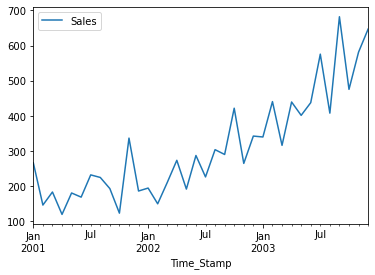

In [7]:
df.plot()

**From the above graph, we can see that th data is seasonal**

## Sales Trend - Yearly, Monthly, Quaterly

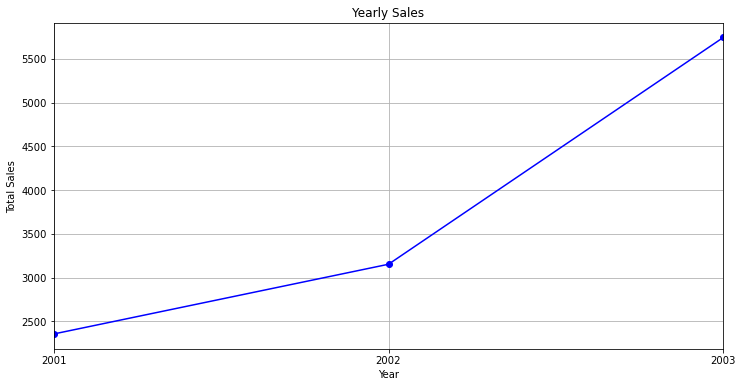

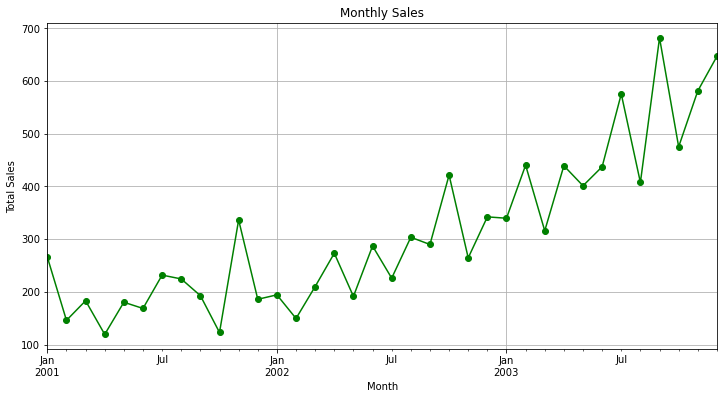

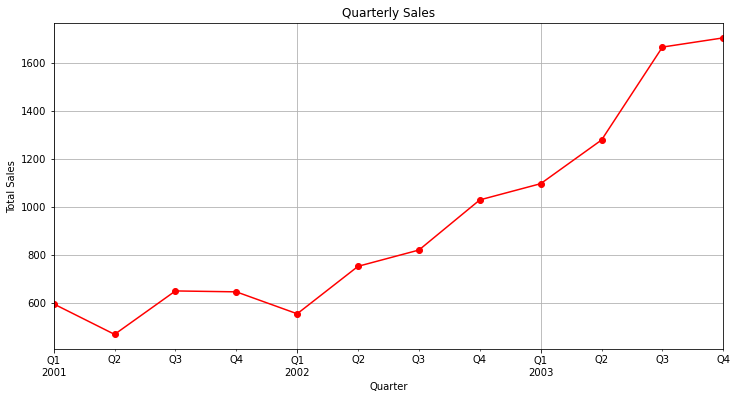

In [8]:
# Convert the index to datetime format (if not already)
df.index = pd.to_datetime(df.index)

# Yearly plot
plt.figure(figsize=(12, 6))
df.resample('Y')['Sales'].sum().plot(marker='o', linestyle='-', color='b')
plt.title('Yearly Sales')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Monthly plot
plt.figure(figsize=(12, 6))
df.resample('M')['Sales'].sum().plot(marker='o', linestyle='-', color='g')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Quarterly plot
plt.figure(figsize=(12, 6))
df.resample('Q')['Sales'].sum().plot(marker='o', linestyle='-', color='r')
plt.title('Quarterly Sales')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

## Checking if data is statonary

In [9]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")
        
adf_test(df['Sales'])

ADF Statistics: 3.0601420836411815
p- value: 1.0
Weak evidence against null hypothesis, time series is non-stationary 


**The value of p value is greater than 0.05, hence differencing is necessary**

## Differencing

In [10]:
df['Sales First Difference']=df['Sales']-df['Sales'].shift(1)

In [11]:
adf_test(df['Sales First Difference'].dropna())

ADF Statistics: -7.249074055553854
p- value: 1.7998574141687034e-10
Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary


In [12]:
### 12 months 
df['Sales 12 Difference']=df['Sales']-df['Sales'].shift(12)

In [13]:
adf_test(df['Sales 12 Difference'].dropna())

ADF Statistics: -0.045615534142483816
p- value: 0.9545931714075303
Weak evidence against null hypothesis, time series is non-stationary 


In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

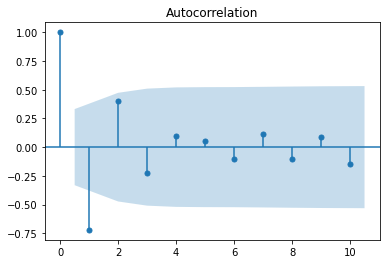

In [15]:
acf = plot_acf(df["Sales First Difference"].dropna(), lags=10)

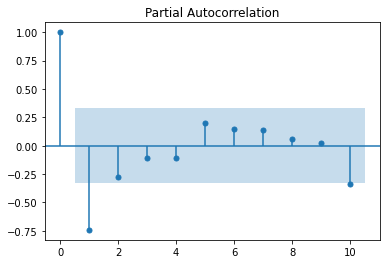

In [16]:
pacf = plot_pacf(df["Sales First Difference"].dropna(), lags=10)

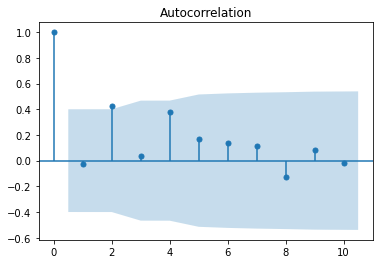

In [17]:
acf = plot_acf(df["Sales 12 Difference"].dropna(), lags=10)

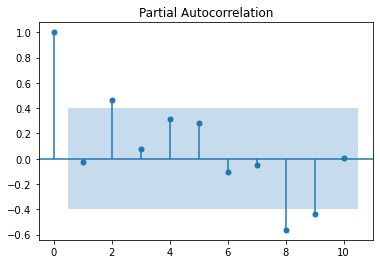

In [18]:
pacf = plot_pacf(df["Sales 12 Difference"].dropna(), lags=10)

## Train Test Split the Data

In [19]:
df.sort_values(by='Time_Stamp', inplace=True)

# Set the percentage split for training (e.g., 80%)
train_percentage = 0.8
split_index = int(train_percentage * len(df))

# Split the data into training and test sets
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

# Print the shapes of the training and test sets
print("Training set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

Training set shape: (28, 3)
Test set shape: (8, 3)


## Fitting the SARIMAX Model

In [20]:
# Fit the initial SARIMA model
initial_model = SARIMAX(train_data['Sales'], order=(1, 1, 1), seasonal_order=(2, 1, 0, 12), freq='M')
initial_results = initial_model.fit(disp=False)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Hyperparameter Tuning

In [21]:
# Hyperparameter Tuning
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
hyperparameter_grid = list(itertools.product(p, d, q, P, D, Q))

best_model = None
best_aic = float('inf')

for params in hyperparameter_grid:
    model = SARIMAX(train_data['Sales'], order=(params[0], params[1], params[2]), 
                                    seasonal_order=(params[3], params[4], params[5], 12), freq='M')
    results = model.fit(disp=False)
    aic = results.aic
    
    if aic < best_aic:
        best_aic = aic
        best_model = model

print("Best hyperparameters:", best_model.order, best_model.seasonal_order)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

Best hyperparameters: (0, 1, 1) (0, 1, 0, 12)


## Evaluation Metrics

In [22]:
# Evaluation Metrics
best_model_results = best_model.fit(disp=False)
predictions = best_model_results.get_forecast(steps=len(test_data))
predicted_values = predictions.predicted_mean

mae = mean_absolute_error(test_data['Sales'], predicted_values)
mse = mean_squared_error(test_data['Sales'], predicted_values)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 122.34576028259691
Mean Squared Error (MSE): 21210.45548385534
Root Mean Squared Error (RMSE): 145.638097638823


## Predicting the values

In [23]:
future_steps = 10  # Adjust the number of steps as needed
forecast = best_model_results.get_forecast(steps=future_steps)
future_predictions = forecast.predicted_mean

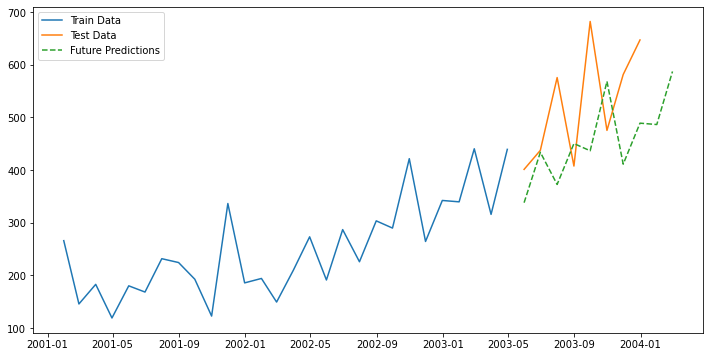

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train Data')
plt.plot(test_data['Sales'], label='Test Data')
plt.plot(future_predictions.index, future_predictions, label='Future Predictions', linestyle='dashed')
plt.legend()
plt.show()

## Checking the Residuals 

In [25]:
# Residuals
residuals = best_model_results.resid
residuals

Time_Stamp
2001-01-31    266.000000
2001-02-28   -118.865848
2001-03-31     36.107501
2001-04-30    -63.468121
2001-05-31     60.416639
2001-06-30    -11.244686
2001-07-31     63.196646
2001-08-31     -6.719134
2001-09-30    -31.761758
2001-10-31    -70.191935
2001-11-30    212.954837
2001-12-31   -148.642646
2002-01-31   -127.789427
2002-02-28     73.015884
2002-03-31     58.802956
2002-04-30    163.857098
2002-05-31    -30.167806
2002-06-30     85.732497
2002-07-31    -61.356963
2002-08-31     39.319329
2002-09-30     47.399375
2002-10-31    237.169375
2002-11-30   -192.360913
2002-12-31     83.587999
2003-01-31     51.967265
2003-02-28    184.661691
2003-03-31    -45.912698
2003-04-30     25.589533
dtype: float64

<AxesSubplot:xlabel='Time_Stamp'>

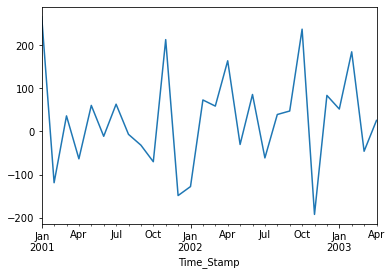

In [26]:
residuals.plot()

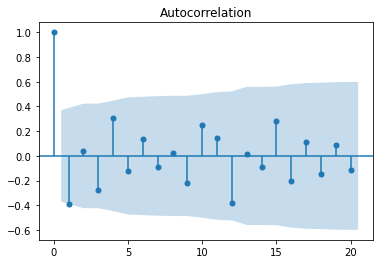

In [27]:
plot_acf(residuals, lags=20)
plt.show()

In [28]:
predicted_values = best_model_results.get_prediction(start=train_data.index[0], end=train_data.index[-1]).predicted_mean

residuals_df = pd.DataFrame({
    
    'Observed_Values': train_data['Sales'].loc[residuals.index],
    'Predicted_Values': predicted_values.values,
    'Residuals': residuals.values
})

# Print or display the DataFrame
print(residuals_df)


            Observed_Values  Predicted_Values   Residuals
Time_Stamp                                               
2001-01-31            266.0          0.000000  266.000000
2001-02-28            145.9        264.765848 -118.865848
2001-03-31            183.1        146.992499   36.107501
2001-04-30            119.3        182.768121  -63.468121
2001-05-31            180.3        119.883361   60.416639
2001-06-30            168.5        179.744686  -11.244686
2001-07-31            231.8        168.603354   63.196646
2001-08-31            224.5        231.219134   -6.719134
2001-09-30            192.8        224.561758  -31.761758
2001-10-31            122.9        193.091935  -70.191935
2001-11-30            336.5        123.545163  212.954837
2001-12-31            185.9        334.542646 -148.642646
2002-01-31            194.3        322.089427 -127.789427
2002-02-28            149.5         76.484116   73.015884
2002-03-31            210.1        151.297044   58.802956
2002-04-30    

<AxesSubplot:xlabel='Time_Stamp'>

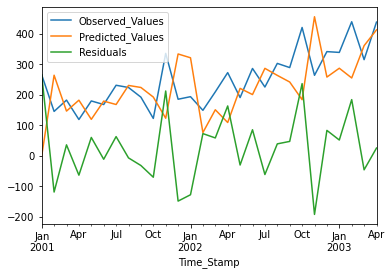

In [29]:
residuals_df.plot()